### Biological diagnostics, using timeseries files

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
from statistics import mean
from matplotlib import style
from scipy import stats
#style.use('ggplot')

import matplotlib.colors as colors

In [2]:
case = 'g.e21.G1850ECOIAF.T62_g16.004'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'

In [3]:
variables = ['sp_Fe_lim_surf','sp_P_lim_surf','sp_N_lim_surf',
             'diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf','diat_SiO3_lim_surf','diaz_P_lim_surf',
             'diaz_Fe_lim_surf','photoC_TOT_zint','photoC_sp_zint','photoC_diat_zint','photoC_diaz_zint',
             'CaCO3_PROD_zint','SiO2_PROD','POC_FLUX_100m','spCaCO3','NO3', 'PO4'] #'spChl','diatChl','diazChl
coords = {'x':'TLONG','y':'TLAT'}

In [4]:
keepthese = ['z_t','z_t_150m','time_bound','TAREA','REGION_MASK', 'time']

In [5]:
%%time

ds_list = []

print(f'reading {case}')

ds = xr.Dataset()

for v in variables:
    
    print(v)
    
    #files = sorted(glob(f'{path}/{case}.pop.h.{v}.000101-006212.nc'))       #if just wanting first IAF
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.??????-??????.nc'))     
    #print(files)
    
    #dsv = xr.open_mfdataset(files, decode_times=True, decode_coords=False)
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e21.G1850ECOIAF.T62_g16.004
sp_Fe_lim_surf
sp_P_lim_surf
sp_N_lim_surf
diat_Fe_lim_surf
diat_P_lim_surf
diat_N_lim_surf
diat_SiO3_lim_surf
diaz_P_lim_surf
diaz_Fe_lim_surf
photoC_TOT_zint
photoC_sp_zint
photoC_diat_zint
photoC_diaz_zint
CaCO3_PROD_zint
SiO2_PROD
POC_FLUX_100m
spCaCO3
NO3
PO4
CPU times: user 17.5 s, sys: 901 ms, total: 18.4 s
Wall time: 34 s


#### Make an annual mean, using the last 10 years

In [6]:
tlen=len(ds.time)
tlen

1488

In [7]:
#resetting the time variable so that it's a mean of the time bounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [8]:
ds_annmean = xr.Dataset()
for v in variables:
    ds_annmean[v] = ds[v].isel(time=slice(-120,tlen)).mean(dim='time')

In [9]:
ds_annmean

<xarray.Dataset>
Dimensions:             (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t                 (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m            (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    sp_Fe_lim_surf      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    sp_P_lim_surf       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    sp_N_lim_surf       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    diat_Fe_lim_surf

In [10]:
#make a dataset with just annual means
ds_annmean_ts=ds.resample({'time':'A'}).mean(dim='time')
#ds_annmean_ts

In [11]:
#just getting this for the coords (that don't have nans)
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_POPgrid.nc'
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
z_t = ds.z_t
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01
years = np.arange(len(ds_annmean_ts.time)) + 1

### Phytoplankton nutrient limitation at surface maps

In [12]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)

limarray_sp=xr.concat((ds_annmean.sp_P_lim_surf, ds_annmean.sp_Fe_lim_surf,ds_annmean.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((ds_annmean.diat_P_lim_surf, ds_annmean.diat_Fe_lim_surf, ds_annmean.diat_N_lim_surf, ds_annmean.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((ds_annmean.diaz_P_lim_surf, ds_annmean.diaz_Fe_lim_surf),dim='nutrient')

In [13]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
mask = np.isnan(ds_annmean.sp_N_lim_surf.squeeze())

In [14]:
most_lim_sp = most_lim_sp.squeeze()
most_lim_diat = most_lim_diat.squeeze()
most_lim_diaz = most_lim_diaz.squeeze()

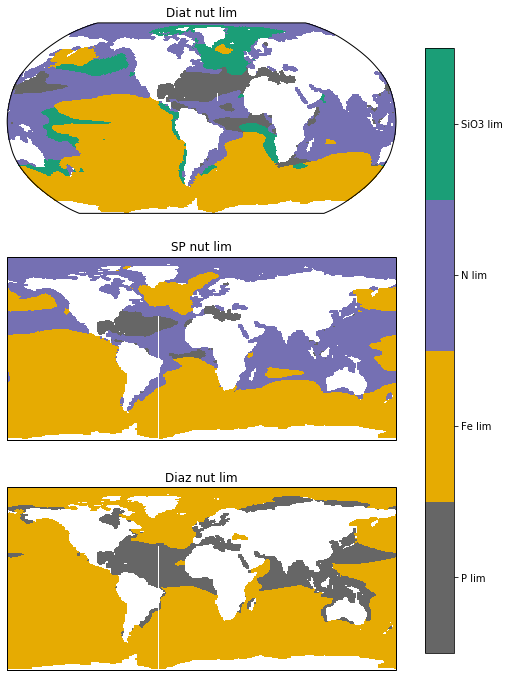

In [15]:
fig = plt.figure(figsize=(8,12))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diat nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_diat.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_title('SP nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_sp.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5)
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_title('Diaz nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_diaz.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5)
colorbar_specs = {'ticks' : np.arange(0,4,1)}

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3 lim']);

### NPP

nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

In [25]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'TOT']]

ds_glb = xr.Dataset()
for v in variables:
    ds_glb[v] = esmlab.statistics.weighted_sum(ds_annmean[v], weights=area, dim=['nlat', 'nlon'])
    ds_glb[v].attrs = ds_annmean[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()
ds_glb

<xarray.Dataset>
Dimensions:           ()
Data variables:
    photoC_diat_zint  float64 16.6
    photoC_sp_zint    float64 29.48
    photoC_diaz_zint  float64 1.557
    photoC_TOT_zint   float64 47.64

Globally integrated NPP should be between 50 and 60 Pg C yr$^{-1}$ according to satellite derived NPP algorithms

#### Look at drift in total and phytoplankton NPP

In [26]:
ts_glb=xr.Dataset()
ts_glb['photoC_TOT_zint'] = esmlab.statistics.weighted_sum(ds_annmean_ts['photoC_TOT_zint'], weights=area, dim=['nlat', 'nlon'])
ts_glb['photoC_TOT_zint'] = ts_glb['photoC_TOT_zint'] * nmols_to_PgCyr

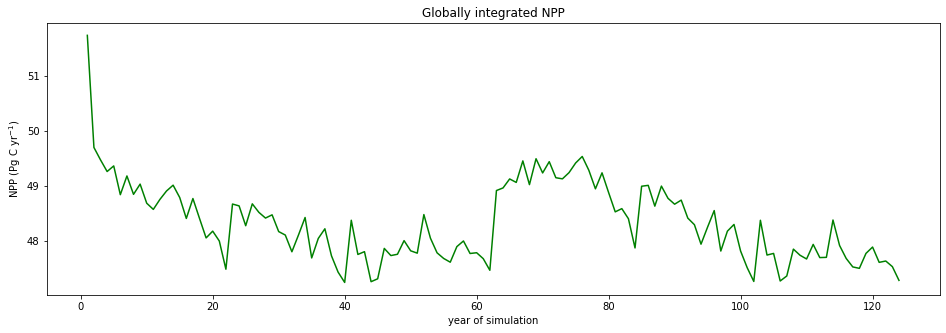

In [27]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Globally integrated NPP')
ax.plot(years,ts_glb['photoC_TOT_zint'],color='green')
ax.set(ylabel='NPP (Pg C yr$^{-1}$)',xlabel='year of simulation');

#### Look at drift of NPP by each PFT

In [28]:
ts_glb['photoC_sp_zint'] = esmlab.statistics.weighted_sum(ds_annmean_ts['photoC_sp_zint'], weights=area, dim=['nlat', 'nlon'])
ts_glb['photoC_sp_zint'] = ts_glb['photoC_sp_zint'] * nmols_to_PgCyr
ts_glb['photoC_diat_zint'] = esmlab.statistics.weighted_sum(ds_annmean_ts['photoC_diat_zint'], weights=area, dim=['nlat', 'nlon'])
ts_glb['photoC_diat_zint'] = ts_glb['photoC_diat_zint'] * nmols_to_PgCyr
ts_glb['photoC_diaz_zint'] = esmlab.statistics.weighted_sum(ds_annmean_ts['photoC_diaz_zint'], weights=area, dim=['nlat', 'nlon'])
ts_glb['photoC_diaz_zint'] = ts_glb['photoC_diaz_zint'] * nmols_to_PgCyr

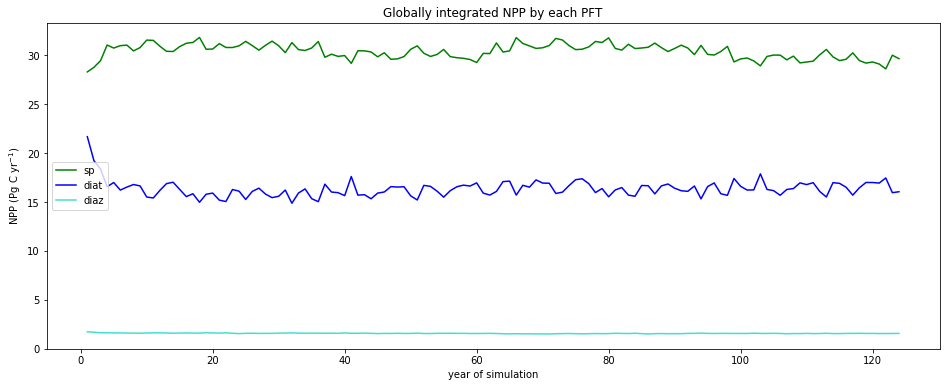

In [29]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(1,1,1)
ax.set_title('Globally integrated NPP by each PFT')
ax.plot(years,ts_glb['photoC_sp_zint'],color='green',label='sp')

ax.plot(years,ts_glb['photoC_diat_zint'],color='blue',label='diat')
ax.plot(years,ts_glb['photoC_diaz_zint'],color='turquoise',label='diaz')


ax.set(ylabel='NPP (Pg C yr$^{-1}$)',xlabel='year of simulation')
ax.legend();

#### Compare to satellite-derived NPP

In [30]:
file_satnpp = '/glade/work/kristenk/satellite_data/POP_regrid/NPP_3methodmean_mean2003-2017_POPgrid.nc'
ds_sat = xr.open_dataset(file_satnpp, decode_times=False)

In [31]:
#convert from mmol/m3 cm/s to gC/m2/y
convert = 1/100. * 60. * 60. * 24. *365. * 1/1000. * 12.011 

In [32]:
diff = ds_annmean.photoC_TOT_zint * convert - ds_sat.NPP

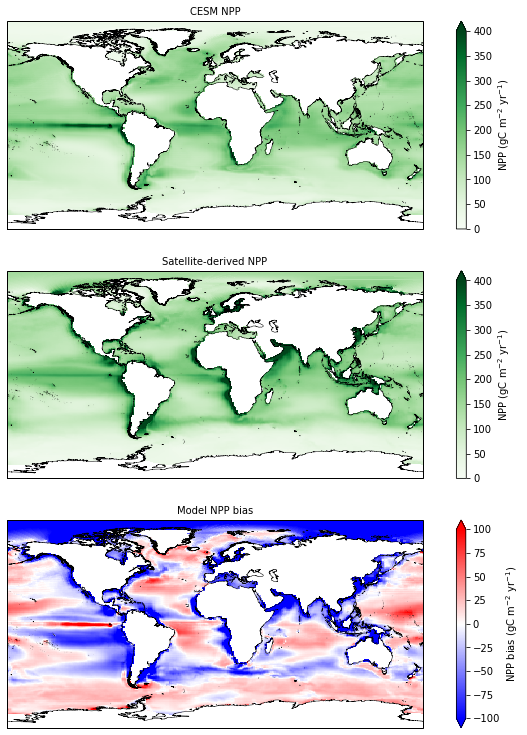

In [33]:
##### ADD SATELLITE-DERIVED NPP COMPARISON
fig = plt.figure(figsize=(12,13))

#---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM NPP', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_annmean.photoC_TOT_zint * convert, 
                  vmin=0, vmax=400, 
                  cmap='Greens',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NPP (gC m$^{-2}$ yr$^{-1}$)')

#---- satellite obs panel
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Satellite-derived NPP', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_sat.NPP, 
                  vmin=0, vmax=400, 
                  cmap='Greens',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NPP (gC m$^{-2}$ yr$^{-1}$)')

#---- diff panel
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Model NPP bias', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 diff, 
                  vmin=-100, vmax=100, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='NPP bias (gC m$^{-2}$ yr$^{-1}$)')

### Calcification

In [34]:
## GLOBALLY integrated calcification; observation-based estimates range from 0.8 to 2.4 Pg CaCO3 per year 
## (Feely et al., 2004, Maranon et al., 2016, Smith et al., 2016, Balch et al., 2007, Iglesias-Rodriguez et al., 2002)
ds_glb['CaCO3_PROD_zint'] = esmlab.statistics.weighted_sum(ds_annmean['CaCO3_PROD_zint'], weights=area, dim=['nlat', 'nlon'])
ds_glb['CaCO3_PROD_zint'] = ds_glb['CaCO3_PROD_zint'] * nmols_to_PgCyr
ds_glb['CaCO3_PROD_zint'].values
print('Globally integrated calcification is',ds_glb['CaCO3_PROD_zint'].values, 'Pg C per year (mean over the last 10 years of the run)')
print('(should be between 0.6 to 2.4 Pg C per year)')

Globally integrated calcification is 0.8272241320961871 Pg C per year (mean over the last 10 years of the run)
(should be between 0.6 to 2.4 Pg C per year)


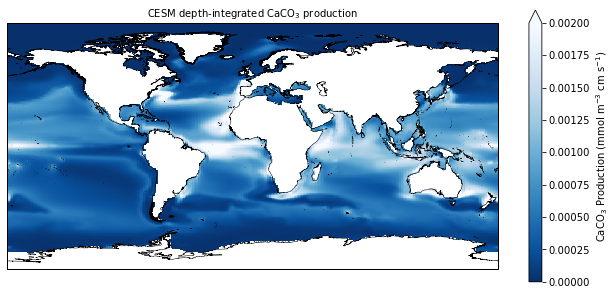

In [35]:
fig = plt.figure(figsize=(11,5))

#---- CESM panel
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM depth-integrated CaCO$_3$ production', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_annmean.CaCO3_PROD_zint, 
                  vmin=0, vmax=0.002, 
                  cmap='Blues_r',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='CaCO$_3$ Production (mmol m$^{-3}$ cm s$^{-1}$)')

#### Timeseries of calcification

In [36]:
ts_glb['CaCO3_PROD_zint'] = esmlab.statistics.weighted_sum(ds_annmean_ts['CaCO3_PROD_zint'], weights=area, dim=['nlat', 'nlon'])
ts_glb['CaCO3_PROD_zint'] = ts_glb['CaCO3_PROD_zint'] * nmols_to_PgCyr

[Text(0, 0.5, 'CaCO$_3$ production (Pg C yr$^{-1}$)'),
 Text(0.5, 0, 'year of simulation')]

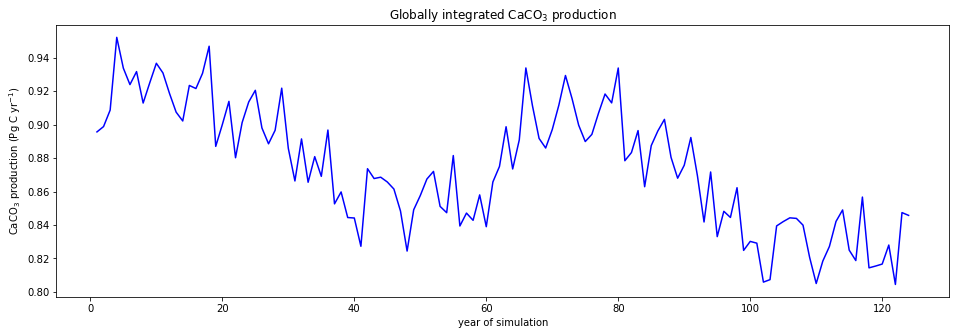

In [37]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Globally integrated CaCO$_3$ production')
ax.plot(years,ts_glb['CaCO3_PROD_zint'],color='blue')
ax.set(ylabel='CaCO$_3$ production (Pg C yr$^{-1}$)',xlabel='year of simulation')

#### Compared satellite-derived Particulate Inorganic Carbon (PIC; i.e., CaCO$_3$) to spCaCO$_3$ in the top 10m

In [38]:
#convert from mmol C/m3 to mg C/m3
convert = 12.011

In [39]:
file_satpic = '/glade/work/kristenk/satellite_data/POP_regrid/PIC_mean2003-2018_POPgrid.nc'
ds_pic = xr.open_dataset(file_satpic, decode_times=False)

In [40]:
diff = ds_annmean.spCaCO3.isel(z_t_150m=0) * convert - ds_pic.PIC

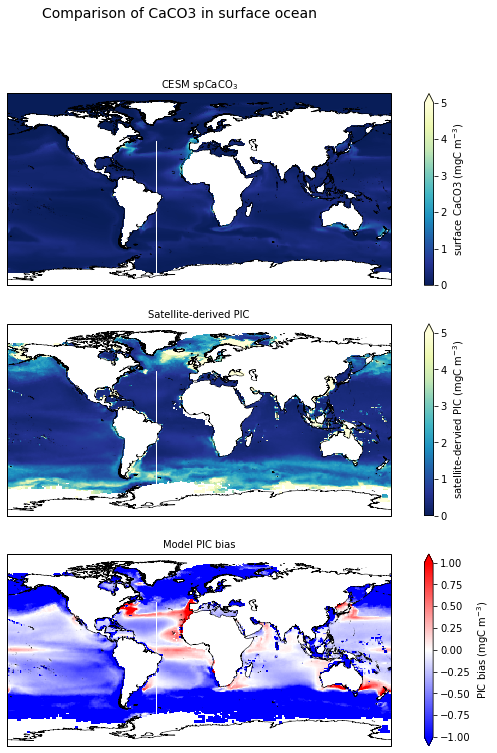

In [41]:
fig = plt.figure(figsize=(12,12))
plt.suptitle('Comparison of CaCO3 in surface ocean', fontsize=14)

#---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM spCaCO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_annmean.spCaCO3.isel(z_t_150m=0) * convert, 
                  vmin=0, vmax=5, 
                  cmap='YlGnBu_r',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='surface CaCO3 (mgC m$^{-3}$)')

#---- satellite obs panel
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Satellite-derived PIC', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_pic.PIC, 
                  vmin=0, vmax=5, 
                  cmap='YlGnBu_r',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='satellite-dervied PIC (mgC m$^{-3}$)')

#---- diff panel
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Model PIC bias', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 diff, 
                  vmin=-1, vmax=1, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='PIC bias (mgC m$^{-3}$)')

### Silicification

In [42]:
# integrate SiO2 production over top 150 m
SiO2_prod_int = ds_annmean['SiO2_PROD'].isel(z_t=slice(0,14)) * 10. #each layer is 10m
SiO2_prod_int = SiO2_prod_int.sum(dim='z_t') #units go from mmolSi/m3/s to mmolSi/m2/s

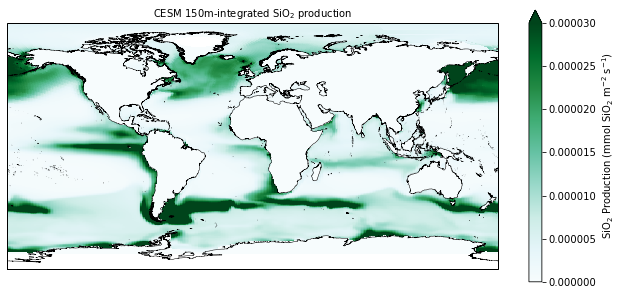

In [43]:
fig = plt.figure(figsize=(11,5))

#---- CESM panel
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM 150m-integrated SiO$_2$ production', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 SiO2_prod_int, 
                  vmin=0, vmax=0.00003, 
                  cmap='BuGn',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_2$ Production (mmol SiO$_2$ m$^{-2}$ s$^{-1}$)')

In [44]:
area.units

'cm^2'

In [45]:
### GLOBALLY integrated biogenic SiO2 production is between 200 and 280 mol Si per year BUT half dissolved in the upper 100m (Nelson et al., 1995)
convert = 1/1000. * 60. * 60. * 24. * 365. #---> converts from mmol Si/m2/sec to  molSi/m2/year
area_m2 = area/10000.
gc_si_prod = SiO2_prod_int * convert * area_m2 #gSi/gc/yr

ds_glb['SiO2_PROD'] = gc_si_prod.sum(dim='nlon').sum(dim='nlat') * 1.e-12

# ds_glb['SiO2_PROD'] = esmlab.statistics.weighted_sum(SiO2_prod_int*convert, weights=area_m2, dim=['nlat', 'nlon'])
# ds_glb['SiO2_PROD'] = ds_glb['SiO2_PROD'] * 1e-12 #convert from gSi to Tg Si  
ds_glb['SiO2_PROD'].values

array(97.45667735)

GLOBALLY integrated biogenic SiO2 production is between 200 and 280 mol Si per year, but half is dissolved in the upper 100m (Nelson et al., 1995)

### POC flux at 100m

In [46]:
ds['POC_FLUX_100m']

<xarray.DataArray 'POC_FLUX_100m' (time: 1488, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(1488, 384, 320), dtype=float32, chunksize=(744, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time     (time) object 0001-01-16 12:59:59 ... 0124-12-16 12:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     POC Flux at 100m
    units:         mmol/m^3 cm/s
    grid_loc:      2110
    cell_methods:  time: mean

In [47]:
ds_glb['POC_FLUX_100m'] = esmlab.statistics.weighted_sum(ds_annmean['POC_FLUX_100m'], weights=area, dim=['nlat', 'nlon'])

In [48]:
ds_glb['POC_FLUX_100m'] = esmlab.statistics.weighted_sum(ds_annmean['POC_FLUX_100m'], weights=area, dim=['nlat', 'nlon'])
ds_glb['POC_FLUX_100m'] = ds_glb['POC_FLUX_100m'] * nmols_to_PgCyr   

In [49]:
ds_glb['POC_FLUX_100m'].values

array(6.97288706)

#### Look at drift in POC FLUX at 100m 

In [50]:
ts_glb['POC_FLUX_100m'] = esmlab.statistics.weighted_sum(ds_annmean_ts['POC_FLUX_100m'], weights=area, dim=['nlat', 'nlon'])
ts_glb['POC_FLUX_100m'] = ts_glb['POC_FLUX_100m'] * nmols_to_PgCyr

In [51]:
ts_glb.compute()

<xarray.Dataset>
Dimensions:           (time: 124)
Coordinates:
  * time              (time) object 0001-12-31 00:00:00 ... 0124-12-31 00:00:00
Data variables:
    photoC_TOT_zint   (time) float64 51.73 49.7 49.47 ... 47.64 47.53 47.28
    photoC_sp_zint    (time) float64 28.31 28.79 29.46 ... 28.62 30.02 29.67
    photoC_diat_zint  (time) float64 21.68 19.23 18.38 ... 17.46 15.96 16.06
    photoC_diaz_zint  (time) float64 1.733 1.678 1.632 ... 1.549 1.555 1.562
    CaCO3_PROD_zint   (time) float64 0.8956 0.8988 0.9087 ... 0.8474 0.8457
    POC_FLUX_100m     (time) float64 8.014 7.57 7.475 ... 7.035 6.905 6.866

[Text(0, 0.5, 'POC flux at 100m (Pg C yr$^{-1}$)'),
 Text(0.5, 0, 'year of simulation')]

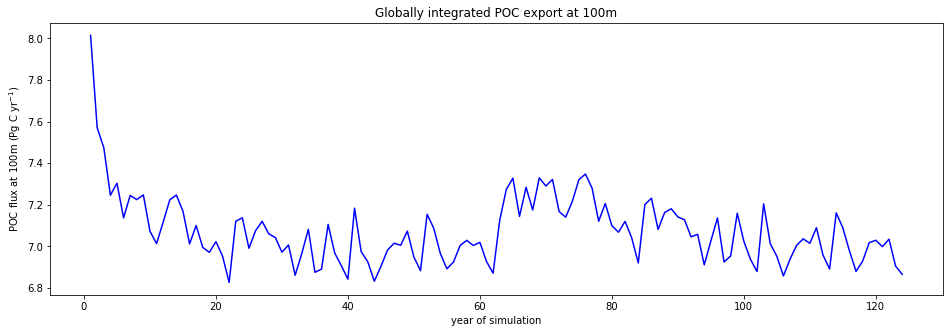

In [52]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Globally integrated POC export at 100m')
ax.plot(years,ts_glb['POC_FLUX_100m'],color='blue')
ax.set(ylabel='POC flux at 100m (Pg C yr$^{-1}$)',xlabel='year of simulation')

### N*, a tracer used to investigate the distribution of nitrogen fixation and denitrification
#### High N* --> nitrogen fixation
#### Low N* --> dentrification
#### (described in Gruber and Sarmiento 1997)

In [54]:
# get WOA for comparison
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_POPgrid.nc'
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = ds.z_t

In [55]:
# convert from mmol/m3 to micromol/kg
convert = 1./1027. * 1000.

In [56]:
#calculate N*
nstar_cesm = 0.87 * (ds_annmean.NO3 * convert - 16. * ds_annmean.PO4 * convert + 2.9)

In [57]:
nstar_woa = 0.87 * (ds_woa.NO3 * convert - 16. * ds_woa.PO4 * convert + 2.9)

In [58]:
diff = nstar_cesm - nstar_woa

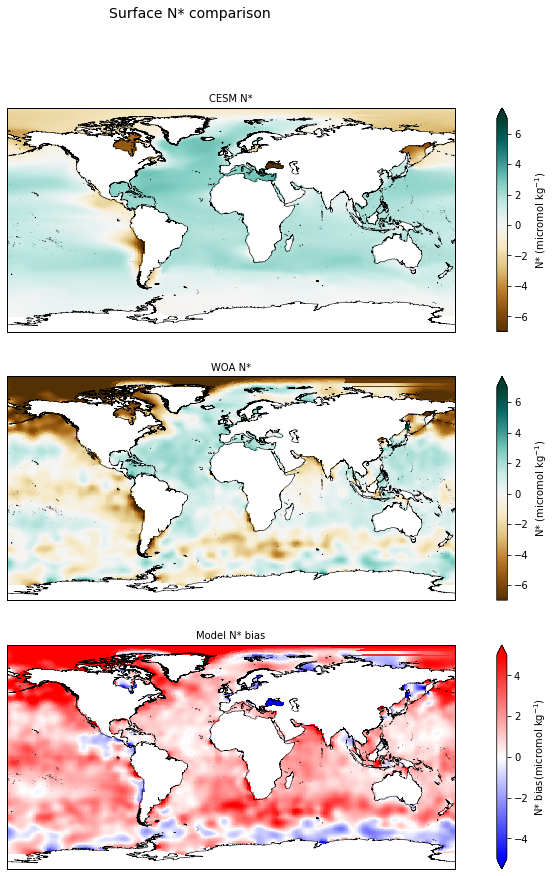

In [59]:
##### 
fig = plt.figure(figsize=(15,14))
plt.suptitle('Surface N* comparison', fontsize=14)
#---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM N*', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 nstar_cesm.isel(z_t=0), 
                  vmin=-7, vmax=7, 
                  cmap='BrBG',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='N* (micromol kg$^{-1}$)')

#---- satellite obs panel
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA N*', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 nstar_woa.isel(z_t=0), 
                  vmin=-7, vmax=7, 
                  cmap='BrBG',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='N* (micromol kg$^{-1}$)')

#---- diff panel
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Model N* bias', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 diff.isel(z_t=0), 
                  vmin=-5, vmax=5, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='N* bias(micromol kg$^{-1}$)')

In [60]:
atl_nstar_transect = nstar_cesm.isel(nlon=10)
pac_nstar_transect = nstar_cesm.isel(nlon=205)
ind_nstar_transect = nstar_cesm.isel(nlon=110)
atl_nstar_transect_woa = nstar_woa.isel(nlon=10)
pac_nstar_transect_woa = nstar_woa.isel(nlon=205)
ind_nstar_transect_woa = nstar_woa.isel(nlon=110)

In [61]:
lats_atl = ds_annmean.TLAT.isel(nlon=10)
lats_pac = ds_annmean.TLAT.isel(nlon=205)
lats_ind = ds_annmean.TLAT.isel(nlon=110)

[Text(0, 0.5, 'depth (m)'), Text(0.5, 0, 'Latitude')]

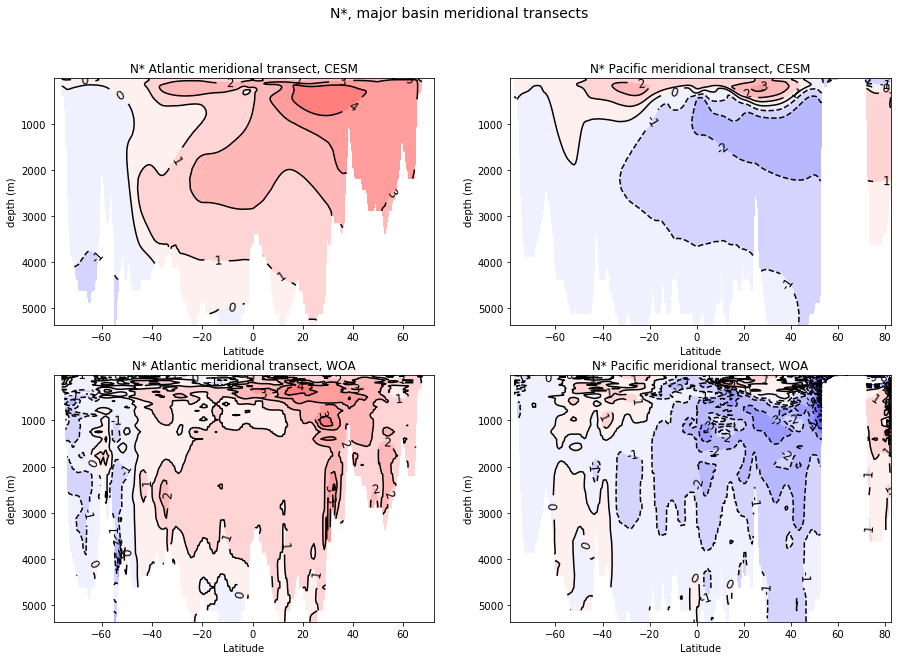

In [62]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('N*, major basin meridional transects', fontsize=14)

levels = [-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9]

#plot 1 cesm atlantic
ax = fig.add_subplot(2,2,1)
ax.set_title('N* Atlantic meridional transect, CESM')
pc=ax.contourf(lats_atl, depths, atl_nstar_transect, levels, cmap='bwr')
contour = plt.contour(lats_atl, depths, atl_nstar_transect, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
plt.gca().invert_yaxis()
ax.set(ylabel='depth (m)', xlabel='Latitude')

#plot 2 cesm atlantic
ax = fig.add_subplot(2,2,2)
ax.set_title('N* Pacific meridional transect, CESM')
pc=ax.contourf(lats_pac, depths, pac_nstar_transect, levels, cmap='bwr')
contour = plt.contour(lats_pac, depths, pac_nstar_transect, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
plt.gca().invert_yaxis()
ax.set(ylabel='depth (m)', xlabel='Latitude')


#plot 1 woa atlantic
ax = fig.add_subplot(2,2,3)
ax.set_title('N* Atlantic meridional transect, WOA')
pc=ax.contourf(lats_atl, depths, atl_nstar_transect_woa, levels, cmap='bwr')
contour = plt.contour(lats_atl, depths, atl_nstar_transect_woa
                      , levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
plt.gca().invert_yaxis()
ax.set(ylabel='depth (m)', xlabel='Latitude')

#plot 2 woa pacific
ax = fig.add_subplot(2,2,4)
ax.set_title('N* Pacific meridional transect, WOA')
pc=ax.contourf(lats_pac, depths, pac_nstar_transect_woa, levels, cmap='bwr')
contour = plt.contour(lats_pac, depths, pac_nstar_transect_woa, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
plt.gca().invert_yaxis()
ax.set(ylabel='depth (m)', xlabel='Latitude')
